# Ramping
Even with robust numerical solvers and thoughtfully chosen default tolerances, simulations may occasionally fail under certain conditions. This is often due to either inconsistent initial conditions or stiffness issues that prevent proper initialization from a rested state. While our solvers are designed to handle many scenarios effectively, the following issues may still arise:

1. **Inconsistent initial conditions:**
   
   Many solvers are capable of detecting and resolving inconsistent initial conditions before taking the first step. However, this feature can be disabled, allowing bad initial conditions to be passed to the solver, and generally resulting in failures.

2. **Stiff problems:**
   
   Some problems are inherently stiff and cannot be initialized effectively, even with a solver's initialization correction schemes. In such cases, the solver may have difficulty determining a stable solution.

To address these issues, introducing a ramped load can stabilize the simulation. By default, `thevenin` models are set to always ask the solver to correct the initial condition. The starting guess that gets passed to the solver is always a rested condition. Therefore, ramped loads can gradually adjust from the initial state to the desired load, making them easier for the solver to handle. This technique helps avoid the solver crashing due to an abrupt change in load.

In this tutorial, we will demonstrate how to use the `loadfns` module to create a ramped load profile. While we will focus one specific function, other useful helper functions are available in the `loadfns` module, and we encourage you to explore the full documentation for more information.

## Creating Ramped Demands
`thevenin` models supports both constant and dynamic load profiles for each experimental step. For example, below we make a profile that discharges the battery at a constant current until 3.5 V and then charges the battery by ramping the voltage until 4.2 V.

In [1]:
import thevenin as thev
import matplotlib.pyplot as plt

def voltage_ramp(t: float) -> float:
    return 3.5 + 5e-3*t

expr = thev.Experiment()
expr.add_step('current_A', 75., (3600., 60.), limits=('voltage_V', 3.5))
expr.add_step('voltage_V', voltage_ramp, (600., 10.), limits=('voltage_V', 4.2))

This general approach provides the most flexibility so users can write any constant or dynamic load, including interpolations of data. However, we also provide select loads in the `loadfns` module that help with both solver stability and reduce the amount of code users need to write out for simple profiles. For instance, the same experiment above can also be constructed using the `Ramp` class, as shown below.

In [2]:
voltage_ramp = thev.loadfns.Ramp(5e-3, 3.5)

expr = thev.Experiment()
expr.add_step('current_A', 75., (3600., 60.), limits=('voltage_V', 3.5))
expr.add_step('voltage_V', voltage_ramp, (600., 10.), limits=('voltage_V', 4.2))

Below, we demonstrate running this experimental protocol so we can see that it is doing what we expect.


[thevenin UserWarning] Using the default parameter file 'params.yaml'.



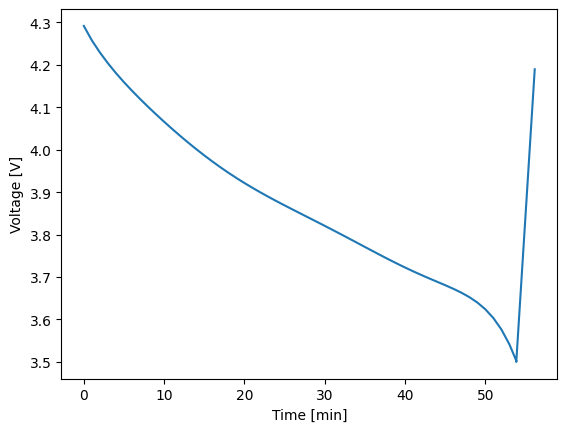

In [3]:
model = thev.Model()

soln = model.run(expr)
soln.plot('time_min', 'voltage_V')

## Stability Ramps
Aside from a constant ramp, like `Ramp` demonstrated above, ramps are also commonly used to quickly move from a rested state to a constant load. This can help with solver stability over trying to instantaneously pull a load. To build this type of provile, use the `Ramp2Constant` class. Below, we ramp up to a 20C discharge in one millisecond and then hold the 20C discharge rate until 3 V.

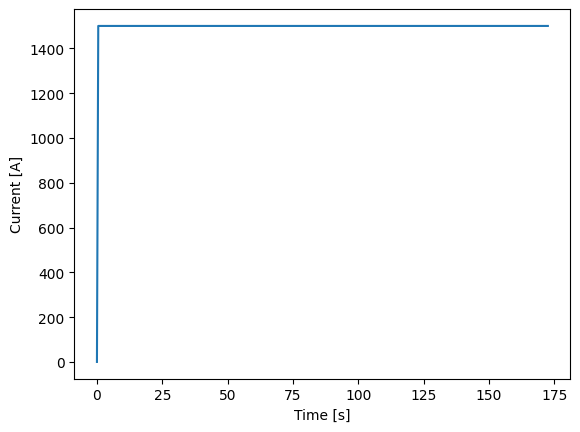

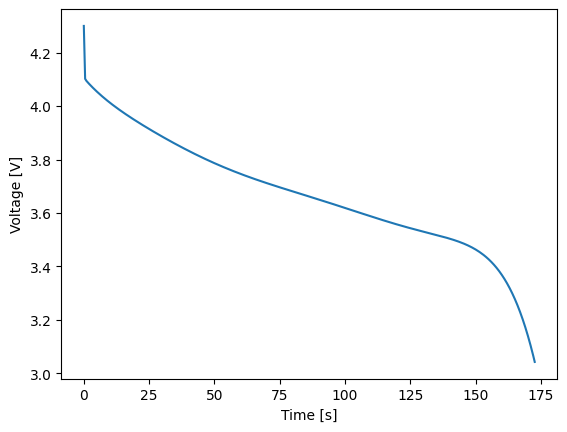

In [4]:
dynamic_load = thev.loadfns.Ramp2Constant(20*75/1e-3, 20*75)

expr = thev.Experiment()
expr.add_step('current_A', dynamic_load, (360., 0.5), limits=('voltage_V', 3.))

soln = model.run(expr)
soln.plot('time_s', 'current_A')
soln.plot('time_s', 'voltage_V')

These types of "stability" ramps become more and more helpful (or needed) as loads become more demanding. They can also depend on the model's parameter set, i.e., for one set of parameters the model may start crashing at a 5C discharge whereas another set is stable up to 50C. 

## Comparing to Instantaneous Demands
The default model parameters, and equivalent circuit models in general, is typically fairly stable compared to other higher-fidelity models (e.g., the single particle model or pseudo-2D model). Therefore, here we can also demonstrate that when we run an instantaneous 20C discharge profile that the results are not significantly impacted. See the figure below that compares the voltage profile above to one obtained without the ramped profile.

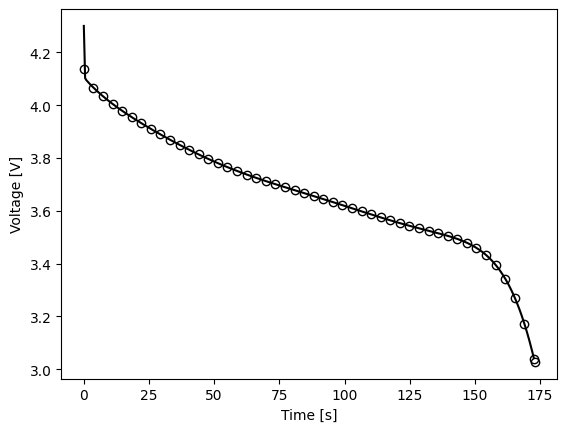

In [5]:
expr = thev.Experiment()
expr.add_step('current_A', 75*20, (180., 50), limits=('voltage_V', 3.))

soln2 = model.run(expr)

plt.plot(soln.vars['time_s'], soln.vars['voltage_V'], '-k')
plt.plot(soln2.vars['time_s'], soln2.vars['voltage_V'], 'ok', markerfacecolor='none')
    
plt.xlabel('Time [s]');
plt.ylabel('Voltage [V]');

Due to the ramp the initial conditions are obviously a bit different. However, since the ramp occurs over just one millisecond, the profile from the ramped case (solid line) very quickly adjusts to the same voltage as the case where current is instantaneous (open markers). The solutions maintain good agreement throughout the rest of discharge.

## Conclusion
In this tutorial, you’ve seen how ramped loads can stabilize simulations that struggle with abrupt load changes. By using the loadfns module, you can easily implement these profiles, ensuring smoother transitions for the solver. For more advanced load functions, check out the full documentation to optimize your simulations further.